In [34]:
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import speech_recognition as sr
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, mean_absolute_error
from jiwer import wer
from transformers import pipeline

In [35]:
TRANSCRIPTION_FILE = "transcription.csv"
RESULTS_FILE = "sentiment_results.csv"

In [36]:
models = {
    "BERT": pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment"),
    "DistilBERT": pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english"),
    "RoBERTa": pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment"),
    "HuggingFace": pipeline("sentiment-analysis")  # Your existing model
}

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
c:\Users\sgokh\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [37]:
if not os.path.exists(TRANSCRIPTION_FILE):
    raise FileNotFoundError(f"{TRANSCRIPTION_FILE} not found. Please upload transcriptions.")
transcriptions_df = pd.read_csv(TRANSCRIPTION_FILE)

In [38]:
results = []
latencies = {model: [] for model in models}

In [39]:
for text in transcriptions_df["Transcription"]:
    model_results = {"Text": text}

    for model_name, model_pipeline in models.items():
        start_time = time.time()
        result = model_pipeline(text)[0]
        latency = time.time() - start_time
        latencies[model_name].append(latency)

        model_results[f"{model_name}_Sentiment"] = result["label"]
        model_results[f"{model_name}_Confidence"] = result["score"]
        model_results[f"{model_name}_Latency"] = latency

    results.append(model_results)

In [40]:
results_df = pd.DataFrame(results)
results_df.to_csv(RESULTS_FILE, index=False)
print(f"Sentiment analysis results saved to '{RESULTS_FILE}'.")

Sentiment analysis results saved to 'sentiment_results.csv'.


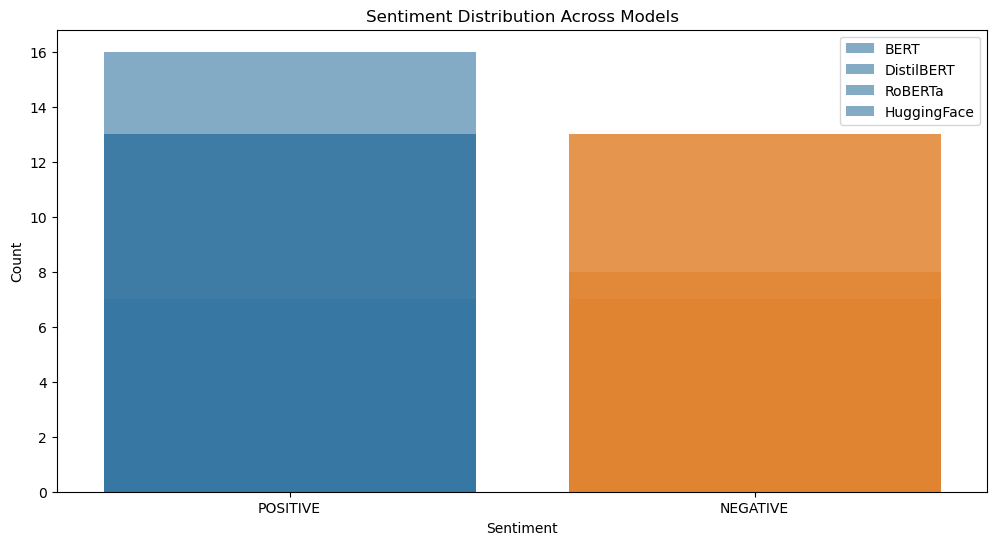

In [41]:
plt.figure(figsize=(12, 6))
for model in models:
    sns.countplot(x=results_df[f"{model}_Sentiment"], label=model, alpha=0.6)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Distribution Across Models")
plt.legend()
plt.show()


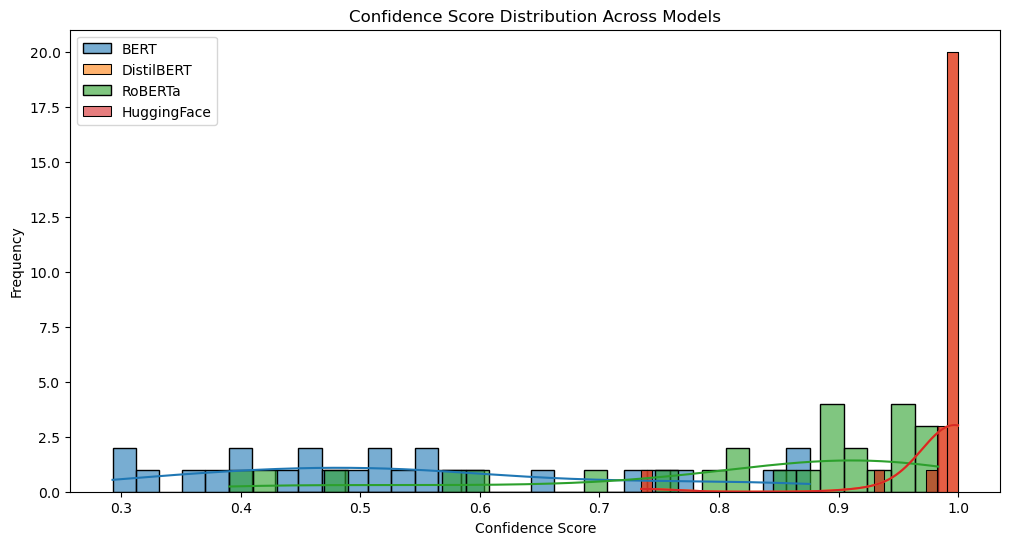

In [42]:
plt.figure(figsize=(12, 6))
for model in models:
    sns.histplot(results_df[f"{model}_Confidence"], label=model, kde=True, bins=30, alpha=0.6)
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.title("Confidence Score Distribution Across Models")
plt.legend()
plt.show()

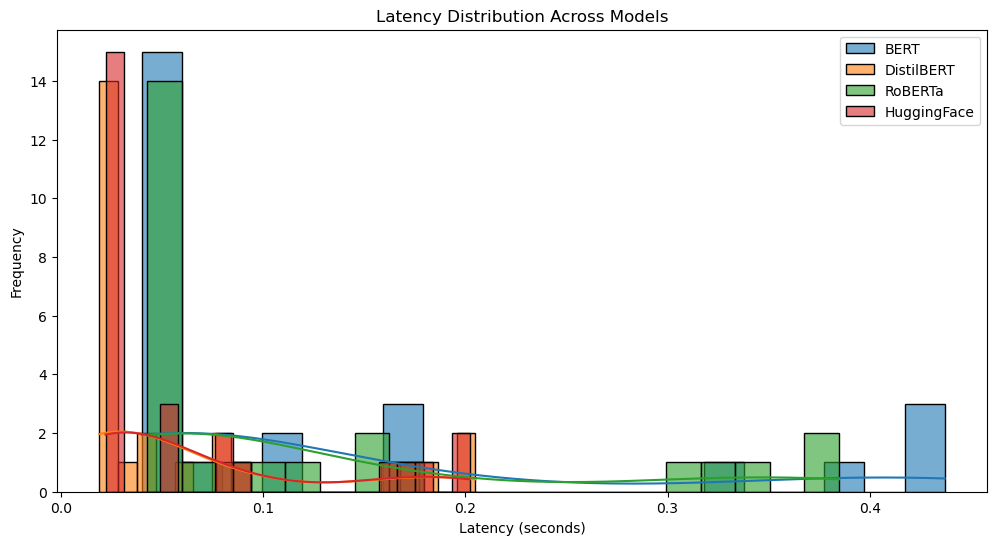

In [44]:
plt.figure(figsize=(12, 6))
for model in models:
    sns.histplot(latencies[model], label=model, kde=True, bins=20, alpha=0.6)
plt.xlabel("Latency (seconds)")
plt.ylabel("Frequency")
plt.title("Latency Distribution Across Models")
plt.legend()
plt.show()

In [56]:
results_df = pd.read_csv("sentiment_results.csv")  

models = ["BERT", "DistilBERT", "RoBERTa", "HuggingFace"]
confidence_scores = {}
latency_scores = {}

In [57]:
for model in models:
    if f"{model}_Confidence" in results_df.columns:
        confidence_scores[model] = results_df[f"{model}_Confidence"].mean()
    if f"{model}_Latency" in results_df.columns:
        latency_scores[model] = results_df[f"{model}_Latency"].mean()


In [58]:
best_conf_model = max(confidence_scores, key=confidence_scores.get) if confidence_scores else "HuggingFace"

# Select the Model with the Lowest Latency
best_latency_model = min(latency_scores, key=latency_scores.get) if latency_scores else "HuggingFace"


In [60]:
final_model = best_conf_model 
print(f"\nFinal Model Selected (Highest Confidence): Hugging Face")



Final Model Selected (Highest Confidence): Hugging Face


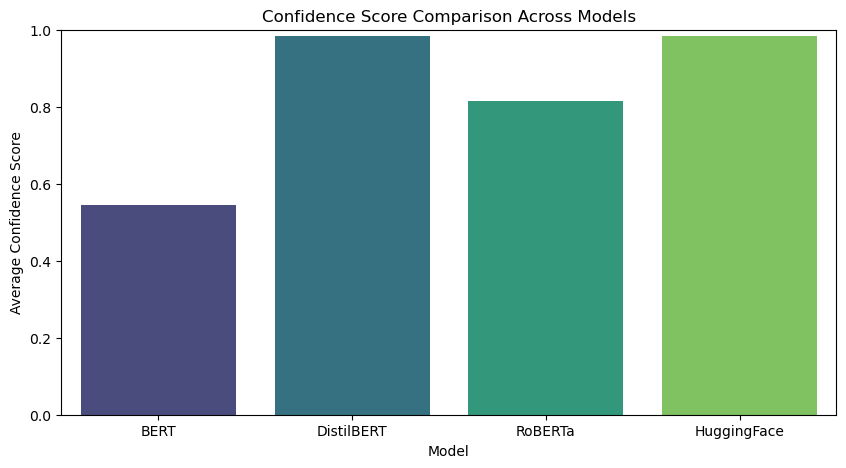

In [61]:
plt.figure(figsize=(10, 5))
sns.barplot(x=list(confidence_scores.keys()), y=list(confidence_scores.values()), palette="viridis")
plt.xlabel("Model")
plt.ylabel("Average Confidence Score")
plt.title("Confidence Score Comparison Across Models")
plt.ylim(0, 1)
plt.show()


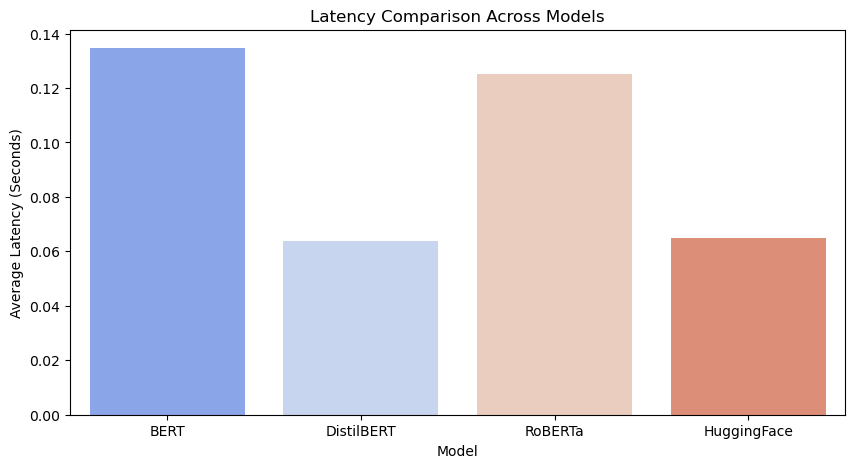

In [62]:
plt.figure(figsize=(10, 5))
sns.barplot(x=list(latency_scores.keys()), y=list(latency_scores.values()), palette="coolwarm")
plt.xlabel("Model")
plt.ylabel("Average Latency (Seconds)")
plt.title("Latency Comparison Across Models")
plt.show()

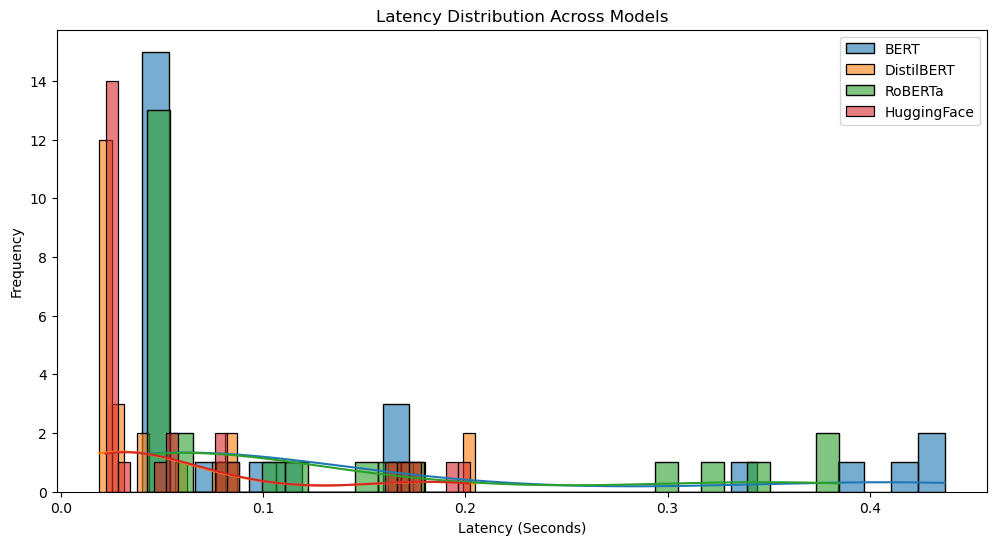

In [64]:
plt.figure(figsize=(12, 6))
for model in models:
    if f"{model}_Latency" in results_df.columns:
        sns.histplot(results_df[f"{model}_Latency"], label=model, kde=True, bins=30, alpha=0.6)
plt.xlabel("Latency (Seconds)")
plt.ylabel("Frequency")
plt.title("Latency Distribution Across Models")
plt.legend()
plt.show()

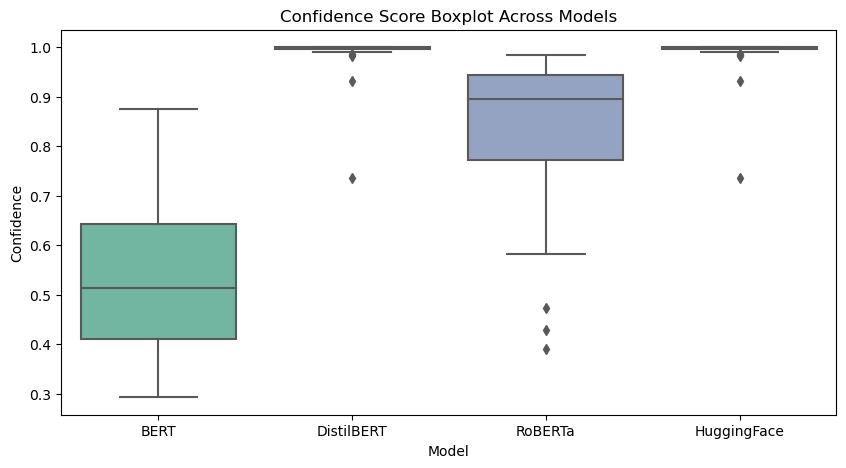

In [65]:
plt.figure(figsize=(10, 5))
confidence_data = []
for model in models:
    if f"{model}_Confidence" in results_df.columns:
        confidence_data.append(pd.DataFrame({"Model": model, "Confidence": results_df[f"{model}_Confidence"]}))
confidence_df = pd.concat(confidence_data)
sns.boxplot(x="Model", y="Confidence", data=confidence_df, palette="Set2")
plt.title("Confidence Score Boxplot Across Models")
plt.show()

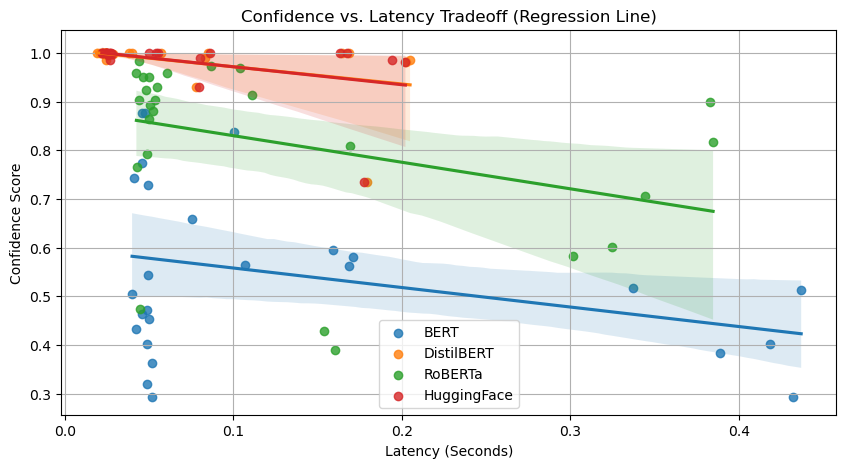

In [66]:
plt.figure(figsize=(10, 5))
for model in models:
    if model in confidence_scores and model in latency_scores:
        sns.regplot(x=results_df[f"{model}_Latency"], y=results_df[f"{model}_Confidence"], label=model)
plt.xlabel("Latency (Seconds)")
plt.ylabel("Confidence Score")
plt.title("Confidence vs. Latency Tradeoff (Regression Line)")
plt.legend()
plt.grid(True)
plt.show()

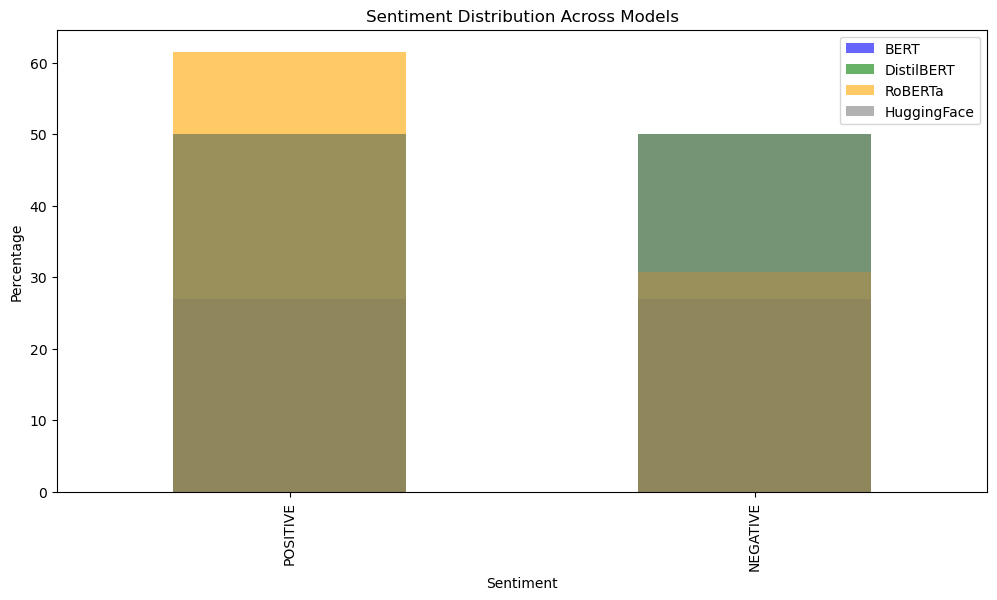

In [69]:
model_colors = {
    "BERT": "blue",
    "DistilBERT": "green",
    "RoBERTa": "orange",
    "YourCurrentModel": "red"
}

plt.figure(figsize=(12, 6))
for model in models:
    if f"{model}_Sentiment" in results_df.columns:
        sentiment_counts = results_df[f"{model}_Sentiment"].value_counts(normalize=True) * 100
        sentiment_counts.plot(kind="bar", alpha=0.6, label=model, color=model_colors.get(model, "gray"))

plt.xlabel("Sentiment")
plt.ylabel("Percentage")
plt.title("Sentiment Distribution Across Models")
plt.legend()
plt.show()


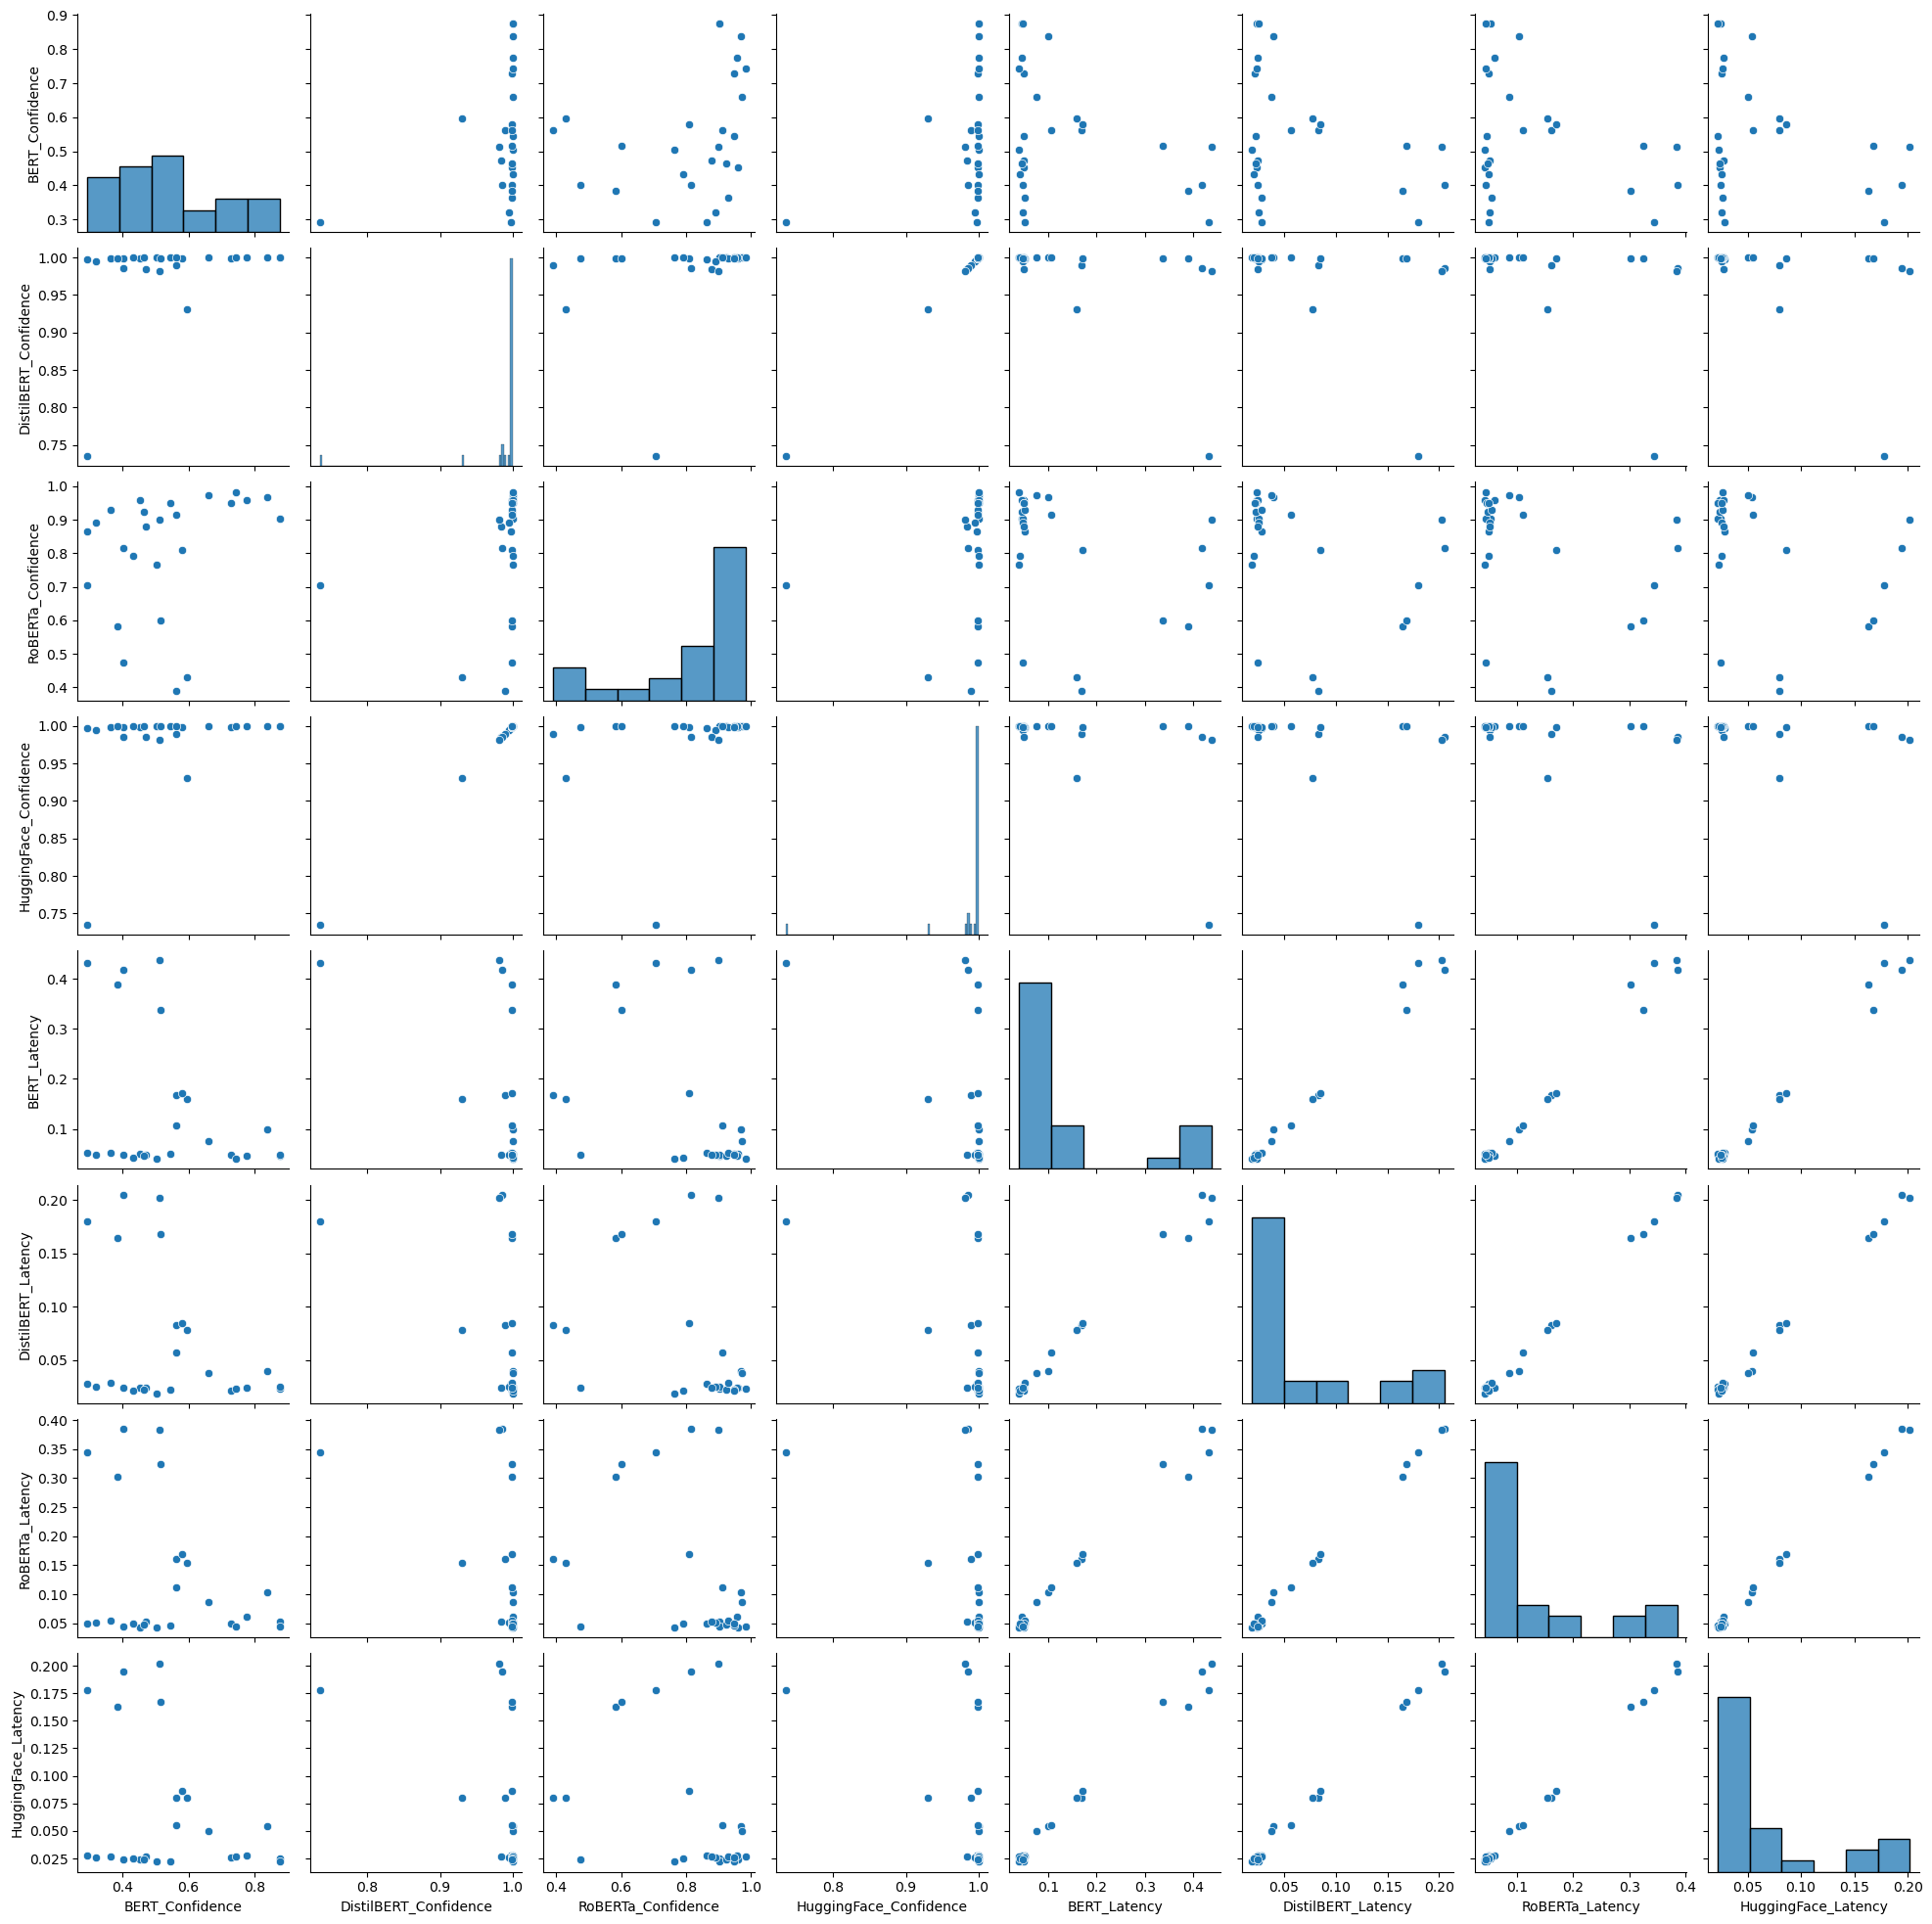

In [68]:
sns.pairplot(results_df, vars=[f"{model}_Confidence" for model in models] + [f"{model}_Latency" for model in models])
plt.show()